## Библиотеки 

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)


import warnings
warnings.filterwarnings("ignore")

## Функции

In [2]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

## Получение данных

In [3]:
df_train = pd.read_csv('data/df_train.csv', sep=';')
df_test = pd.read_csv('data/df_test.csv', sep=';')

In [4]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [5]:
df_train.head()

,Id,Data,Target
0,0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


## EDA

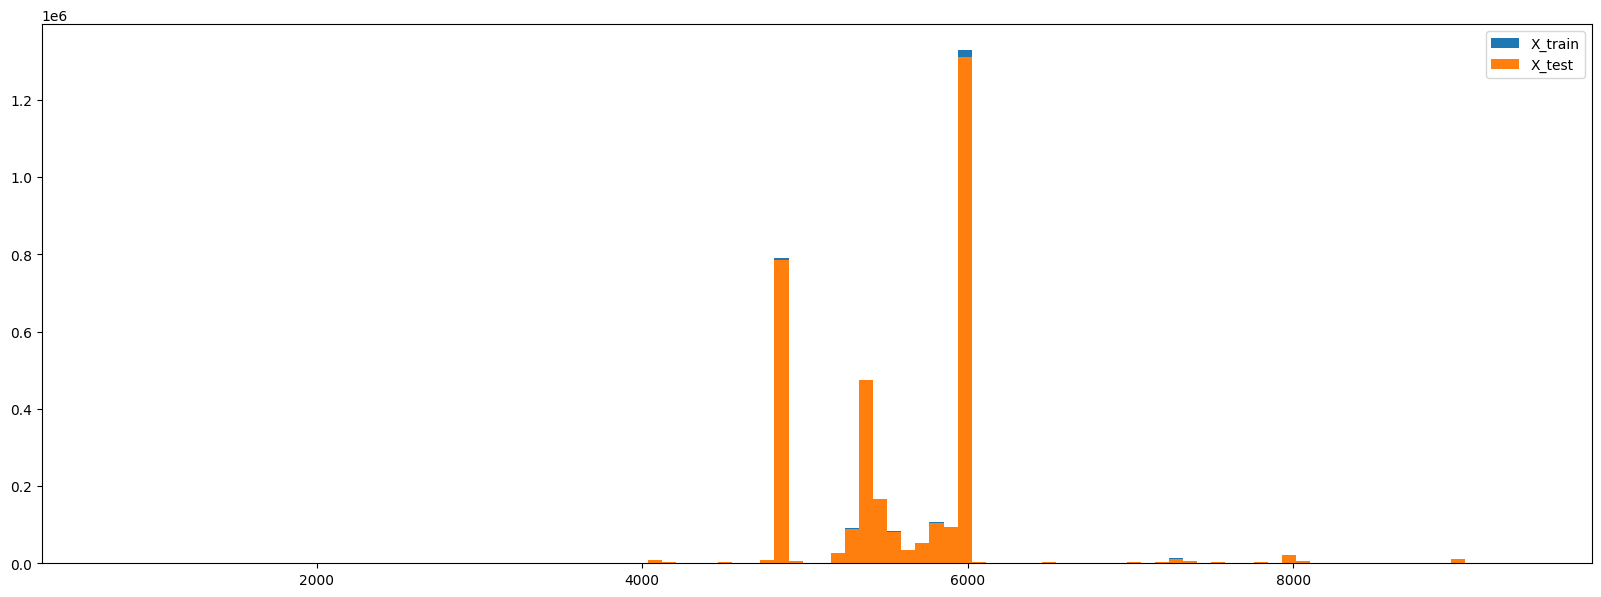

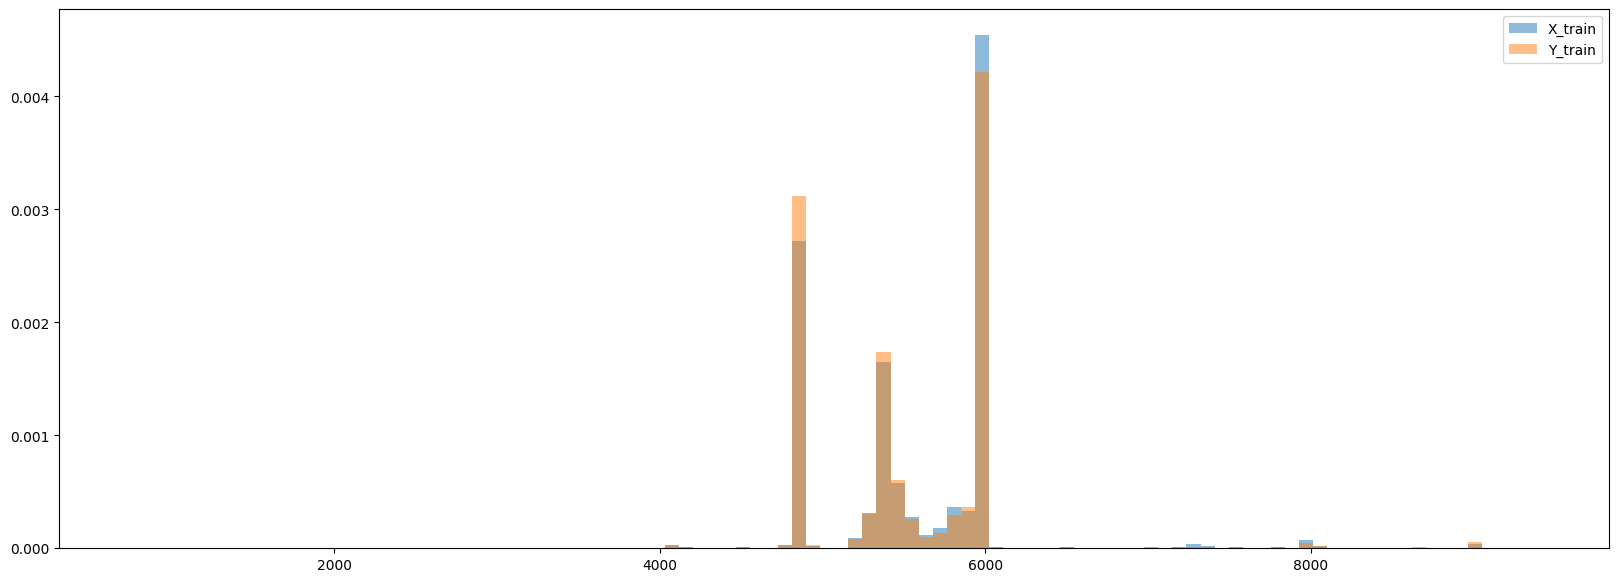

In [6]:
plt.hist(df_test['Data'].explode(), bins=100)
plt.hist(df_train['Data'].explode(), bins=100)
plt.legend(["X_train","X_test"])
plt.show()
# plt.hist(df_test.Target.explode(), bins=100)
plt.hist(df_train.Data.explode(), bins=100, density=1, alpha=0.5)
plt.hist(df_train.Target.explode(), bins=100, density=1, alpha=0.5)
plt.legend(["X_train","Y_train"])

plt.show()

Распределения одинаковые в Х и У. В тесте и трейне

In [7]:
df_train.Data.explode().nunique()

184

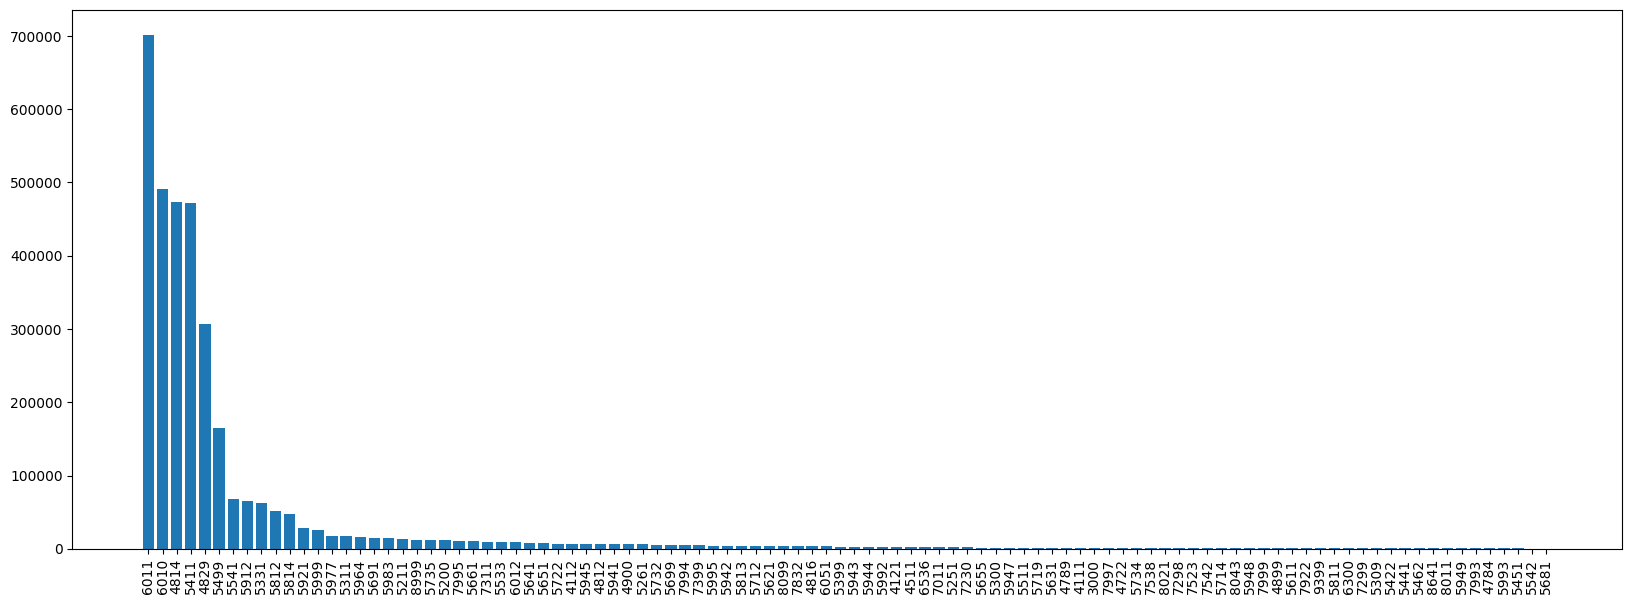

In [8]:
vc = df_train.Data.explode().value_counts()[:100]
plt.bar(list(map(str, vc.index)), vc)
plt.xticks(rotation=90)
plt.show()

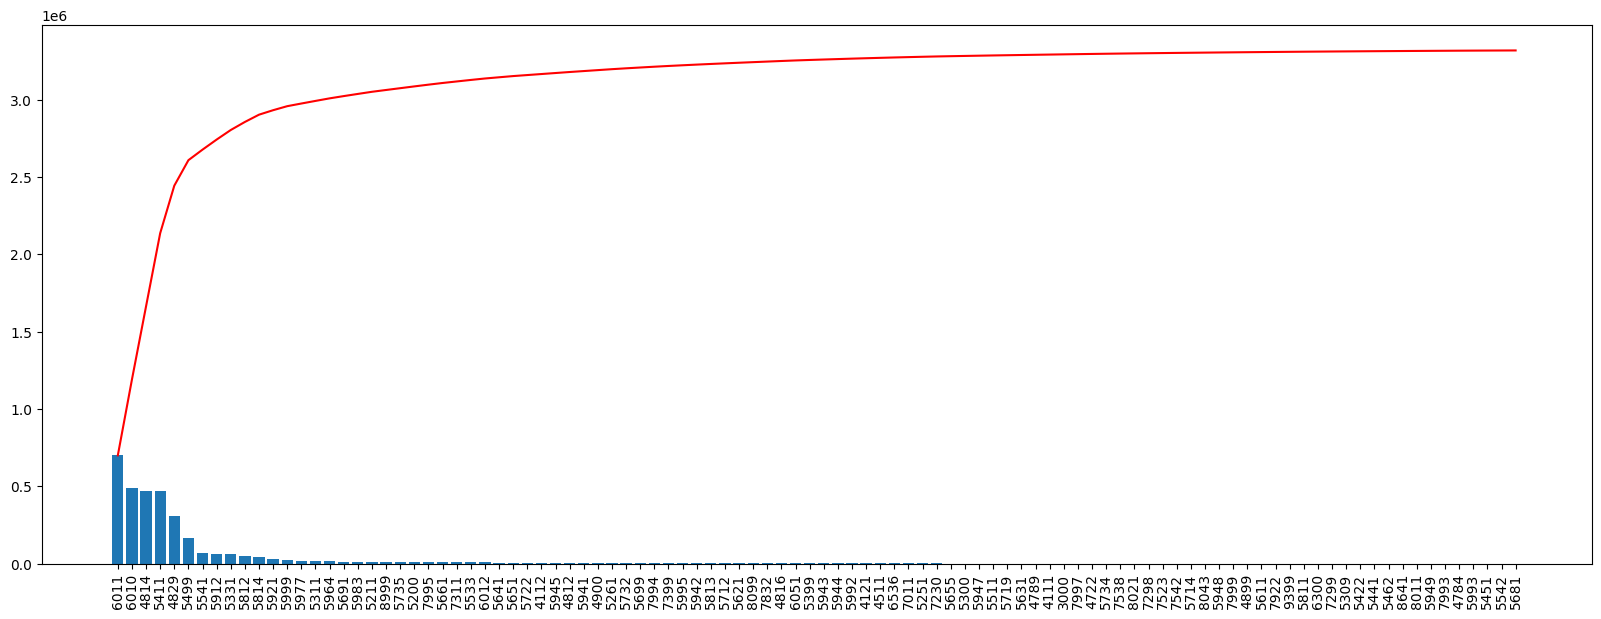

In [9]:
vc = df_train.Data.explode().value_counts()[:100]
xs = list(map(str, vc.index))
plt.plot(xs , vc.cumsum(), c='red')
plt.bar(xs, vc)
plt.xticks(rotation=90)
plt.show()

У нас есть 6 кодов, которые составляют 80% выборки. 
Возможно, все остальные вообще не имеет смысла предсказывать

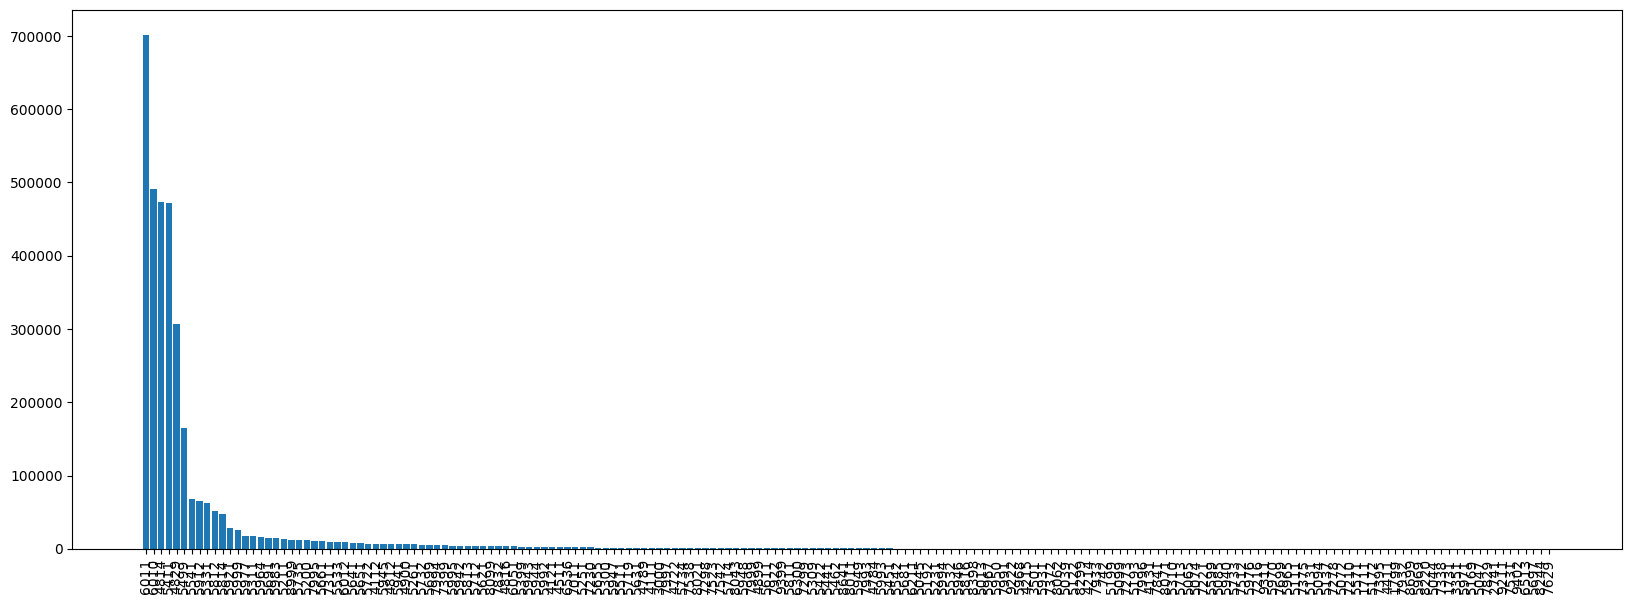

In [10]:
vc = df_train.Data.explode().value_counts()
plt.bar(list(map(str, vc.index)), vc)
plt.xticks(rotation=90)
plt.show()

In [30]:
df_train.Data.explode().value_counts().head(10)

6011    700677
6010    490602
4814    473396
5411    472408
4829    307388
5499    164719
5541     68224
5912     65071
5331     61833
5812     52029
Name: Data, dtype: int64

Самые популярные коды с описанием

In [12]:
# 6011    700677  Финансовые учреждения – снятие наличных автоматически
# 6010    490602  Финансовые учреждения – выдача наличных в кассе
# 4814    473396  Телекоммуникационные услуги
# 5411    472408  Бакалейные магазины, супермаркеты
# 4829    307388  Денежные переводы
# 5499    164719  Различные продовольственные магазины - нигде более не классифицированные
# 5541     68224  Заправочные станции (с вспомогательными услугами или без)
# 5912     65071  Аптеки
# 5331     61833  Универсальные магазины
# 5812     52029  Места общественного питания, рестораны

(array([ 780784.,       0.,       0.,       0.,  534241.,  164719.,
          68224.,       0.,   52029., 1256350.]),
 array([4814. , 4933.7, 5053.4, 5173.1, 5292.8, 5412.5, 5532.2, 5651.9,
        5771.6, 5891.3, 6011. ]),
 <BarContainer object of 10 artists>)

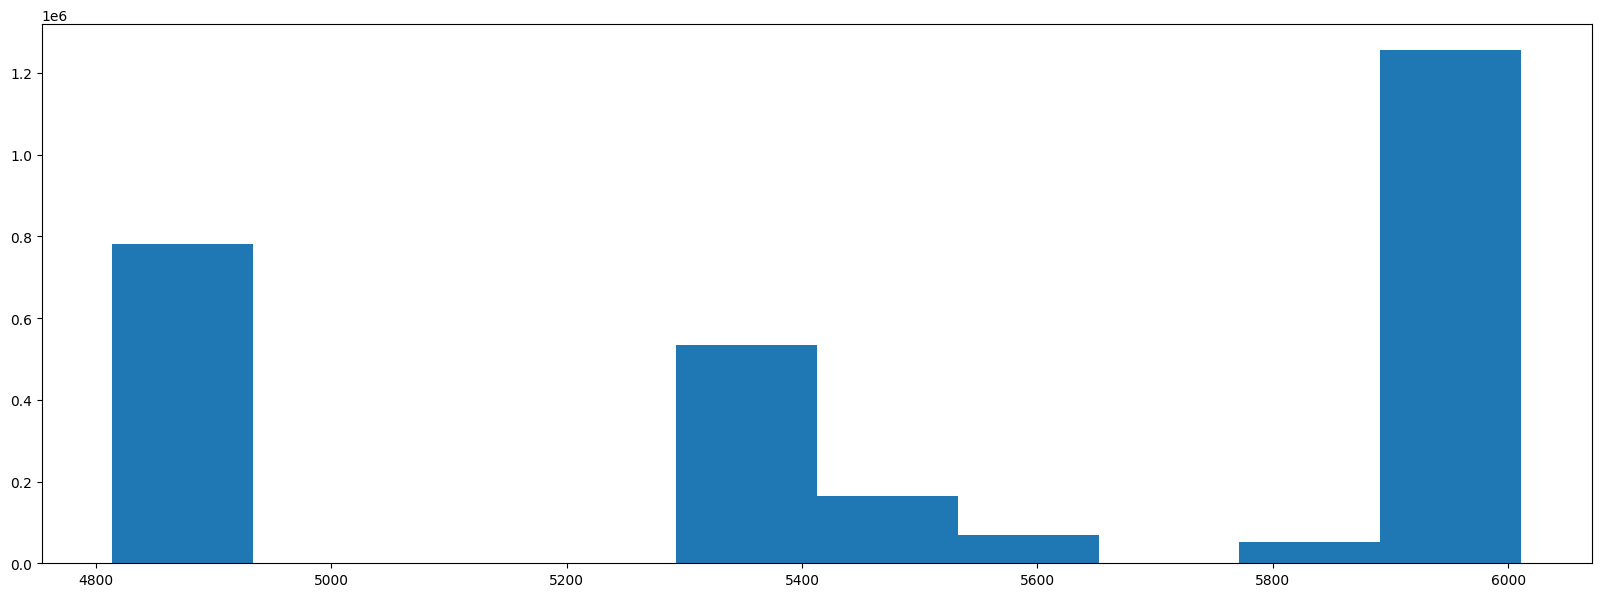

In [13]:
t = pd.Series(df_train.Data.explode())
top10 = df_train.Data.explode().value_counts().head(10).index
plt.hist(t[t.isin(top10)])

### Везде ли есть топ6 кодов?

Константно ли их распрдление внутри людей?

In [45]:
top6_codes = df_train.Data.explode().value_counts().head(6).index
top10_codes = df_train.Data.explode().value_counts().head(10).index
top6_codes

Int64Index([6011, 6010, 4814, 5411, 4829, 5499], dtype='int64')

<AxesSubplot: >

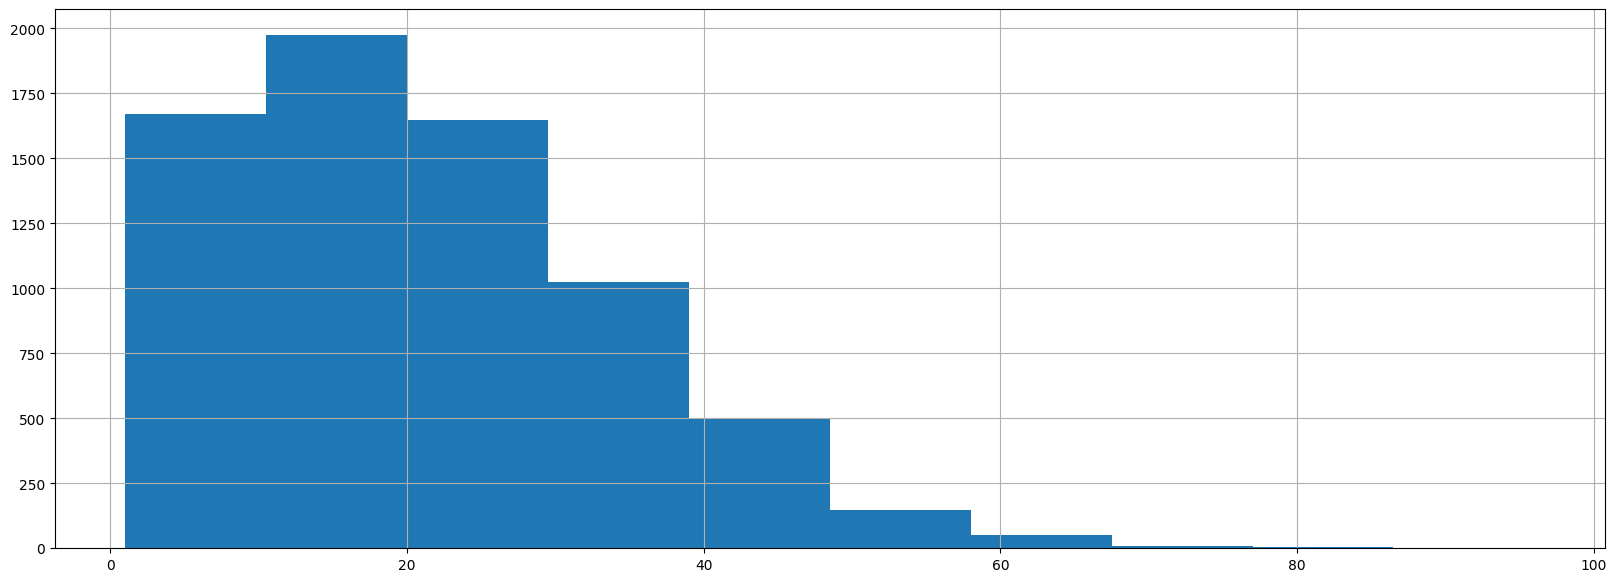

In [37]:
# распредление кол-ва уникальных кодов
df_train.Data.map(set).map(len).hist()
# в среднем, 20-30 разных кодов есть у каждого человека

In [43]:
df_train.Data.map(set).map(lambda codes: all(top_code in codes for top_code in top6_codes)).value_counts()
# все 6 кодов есть только в половине людей

True     3926
False    3107
Name: Data, dtype: int64

In [48]:
df_train.Data.map(set).map(lambda codes: sum(top_code in codes for top_code in top10_codes)).value_counts()


9     1481
10    1427
8     1223
7      932
6      702
5      511
4      415
3      200
2      119
1       23
Name: Data, dtype: int64

In [14]:
df_train.Target

0       [4814, 4814, 4814, 4814, 5411, 4814, 4814, 481...
1       [4814, 6011, 4814, 6011, 4814, 4814, 6011, 481...
2       [6011, 6011, 6010, 4829, 4829, 6010, 6011, 601...
3       [6011, 6011, 6010, 6011, 6011, 4814, 4814, 601...
4       [5499, 6011, 4814, 4829, 5200, 5411, 5499, 591...
                              ...                        
7028    [4814, 5499, 5499, 5411, 5251, 4814, 5499, 549...
7029    [6011, 5261, 6011, 5261, 4814, 5411, 4814, 601...
7030    [6011, 6011, 6011, 6011, 6011, 6011, 6011, 601...
7031    [4814, 6011, 6011, 5999, 5999, 6011, 6011, 601...
7032    [6011, 4829, 6010, 6011, 6011, 5411, 6011, 554...
Name: Target, Length: 7033, dtype: object

In [15]:
len(df_train.Target[0])

10

In [16]:
df_train.shape

(7033, 3)

In [17]:
df_train.dtypes

Id         int64
Data      object
Target    object
dtype: object

In [18]:
df_test.head()

,Id,Data
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481..."


In [19]:
df_test.shape

(7033, 2)

In [20]:
df_test.dtypes

Id       int64
Data    object
dtype: object

## Baseline 1: топ10 MCC-кодов из train-части

MCC-код и соответствующее количество вхождений в train-часть

In [49]:
# top10_codes = df_train['Data'].explode().value_counts().head(10)
# top10_codes

In [50]:
mapk(df_train['Target'], [df_train['Data'].explode().value_counts().head(10).index]*len(df_train))

0.2742435829727881

## Baseline 2: cамые популярные транзакции пользователя.

**Если таких менее 10, то замешиваются топ10 популярных из всей выборки.**

In [52]:
top_all = df_train.Data.explode().value_counts().index
# top_all

In [23]:
def get_top_codes(transactions, top_n=10, drop_from=5):
    transactions_stats = sorted(
        Counter(transactions).items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:top_n]
    

    top_codes = [mcc_code for (mcc_code, count) in transactions_stats if count >= drop_from]
    top_codes += list(top10_codes.index)

    return top_codes[:10]

In [24]:
df_train['pred_baseline_2'] = df_train['Data'].apply(get_top_codes)

In [25]:
df_train['pred_baseline_2']

0       [4814, 6011, 5311, 5411, 6011, 6010, 4814, 541...
1       [4814, 6011, 6011, 6010, 4814, 5411, 4829, 549...
2       [5814, 6010, 4829, 6011, 4814, 5411, 5331, 599...
3       [5411, 4814, 6011, 6010, 6012, 5999, 6011, 601...
4       [4814, 5411, 6011, 4829, 5912, 5499, 6010, 520...
                              ...                        
7028    [5251, 4814, 5499, 6011, 6010, 4829, 5411, 601...
7029    [6011, 4814, 5411, 5912, 6010, 5499, 4900, 581...
7030    [6011, 6011, 6010, 4814, 5411, 4829, 5499, 554...
7031    [6011, 5499, 4814, 5999, 6010, 6011, 6010, 481...
7032    [6011, 4814, 5499, 6010, 5541, 4829, 5411, 601...
Name: pred_baseline_2, Length: 7033, dtype: object

In [26]:
mapk(df_train['Target'], df_train['pred_baseline_2'])

0.3236094127683776

## Submission

предсказания из второго бейзлайна

In [27]:
df_test['Predicted'] = df_test['Data'].apply(get_top_codes)

In [28]:
df_test.head()

,Id,Data,Predicted
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481...","[6011, 4814, 6010, 4829, 5499, 5541, 5411, 601..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601...","[6011, 6010, 5411, 6011, 6010, 4814, 5411, 482..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482...","[6011, 6010, 5499, 4814, 5411, 5814, 4829, 581..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482...","[6011, 4814, 5964, 5411, 4829, 5912, 6010, 601..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481...","[4814, 6011, 6011, 6010, 4814, 5411, 4829, 549..."


In [29]:
submission_baseline_2 = df_test[['Id', 'Predicted']]
submission_baseline_2['Predicted'] = submission_baseline_2.Predicted.astype(str).str.replace(',', '')
submission_baseline_2.to_csv('submission_baseline_2.csv', index=False)